# Chronic Kidney Disease Risk Prediction
This notebook walks through loading, exploring, preprocessing, and modeling the chronic kidney disease (CKD) dataset collected from Bangladeshi patients. It culminates in an XGBoost model that estimates the probability of CKD for a given patient profile.

## 1. Imports & Configuration

In [5]:
import os
import re
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, RocCurveDisplay, accuracy_score)
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='viridis')
plt.rcParams['figure.figsize'] = (10, 6)

DATA_DIR = Path('Dataset')
DATA_PATH = DATA_DIR / 'ckd-dataset-v2.csv'
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

## 2. Load Dataset

In [6]:
raw_df = pd.read_csv(DATA_PATH)
print(f'Raw shape: {raw_df.shape}')
raw_df.head()

Raw shape: (202, 29)


,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12


## 3. Data Cleaning

In [7]:
df = raw_df.copy()
df.columns = [re.sub(r'[^0-9a-zA-Z_]+', '_', col.strip()).strip('_').lower() for col in df.columns]

# Remove metadata rows (e.g., "discrete" and empty descriptor rows)
df = df[df['class'].isin(['ckd', 'notckd'])].copy()

# Replace placeholders and trim whitespace
df = df.replace({'?': np.nan})
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

print(f'Filtered shape: {df.shape}')
df.head()

Filtered shape: (200, 29)


,bp_diastolic,bp_limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12
5,1,1,1.009 - 1.011,3 - 3,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,127.281 - 152.446,s1,1,< 12
6,0,0,1.015 - 1.017,< 0,ckd,0,< 0,0,0,0,...,0,1,0,1,1,0,127.281 - 152.446,s1,1,12 - 20


### 3.1 Helper to convert categorical ranges to numeric

In [8]:
number_regex = re.compile(r'[-+]?[0-9]*?[0-9]+')
categorical_lookup = {'yes': 1, 'no': 0, 'present': 1, 'absent': 0, 'good': 1, 'poor': 0}

def parse_numeric_value(value):
    if pd.isna(value):
        return np.nan
    text = str(value).strip().lower()
    if text in ('', 'nan'):
        return np.nan
    if text in categorical_lookup:
        return categorical_lookup[text]
    if text in ('0', '1'):
        return float(text)
    if text.startswith('s') and text[1:].isdigit():
        return float(text[1:])
    matches = number_regex.findall(text)
    if matches:
        numbers = [float(m) for m in matches]
        return float(np.mean(numbers))
    return np.nan

feature_cols = [col for col in df.columns if col != 'class']
for col in feature_cols:
    df[col] = df[col].apply(parse_numeric_value)

df.head()

,bp_diastolic,bp_limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
2,0.0,0.0,10.5,1.0,ckd,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,585.5,1.0,1.0,12.0
3,0.0,0.0,5.5,0.0,ckd,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,585.5,1.0,1.0,12.0
4,0.0,0.0,5.5,4.0,ckd,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,251.5,1.0,1.0,12.0
5,1.0,1.0,5.5,3.0,ckd,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,251.5,1.0,1.0,12.0
6,0.0,0.0,8.5,0.0,ckd,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,251.5,1.0,1.0,16.0


### 3.2 Data quality summary

In [9]:
df_summary = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': (df.isna().sum() / len(df)) * 100,
    'nunique': df.nunique()
})
df_summary

,missing_count,missing_pct,nunique
bp_diastolic,0,0.0,2
bp_limit,0,0.0,3
sg,0,0.0,5
al,0,0.0,5
class,0,0.0,2
rbc,0,0.0,2
su,0,0.0,5
pc,0,0.0,2
pcc,0,0.0,2
ba,0,0.0,2


## 4. Exploratory Data Analysis

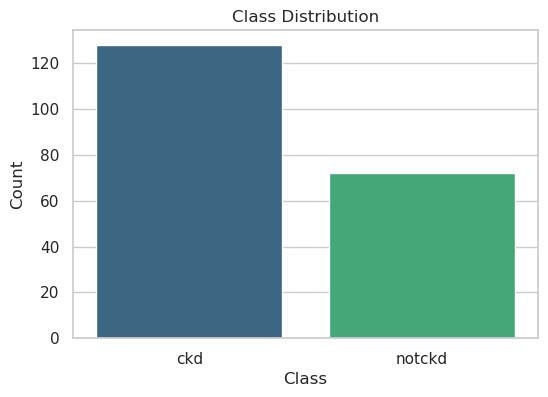

In [10]:
target_counts = df['class'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

In [11]:
numeric_cols = [col for col in feature_cols if df[col].dtype in (np.float64, np.int64)]
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
bp_diastolic,200.0,0.540000,0.499648,0.00,0.00,1.000000,1.00,1.0
bp_limit,200.0,0.755000,0.805119,0.00,0.00,1.000000,1.00,2.0
sg,200.0,9.225000,2.417352,4.00,8.50,10.500000,10.50,12.0
al,200.0,0.980000,1.329828,0.00,0.00,0.000000,2.00,4.0
rbc,200.0,0.125000,0.331549,0.00,0.00,0.000000,0.00,1.0
su,200.0,0.415000,1.063452,0.00,0.00,0.000000,0.00,4.0
pc,200.0,0.225000,0.418630,0.00,0.00,0.000000,0.00,1.0
pcc,200.0,0.135000,0.342581,0.00,0.00,0.000000,0.00,1.0
ba,200.0,0.055000,0.228552,0.00,0.00,0.000000,0.00,1.0
bgr,200.0,157.465000,73.376353,112.00,112.00,133.000000,175.00,448.0


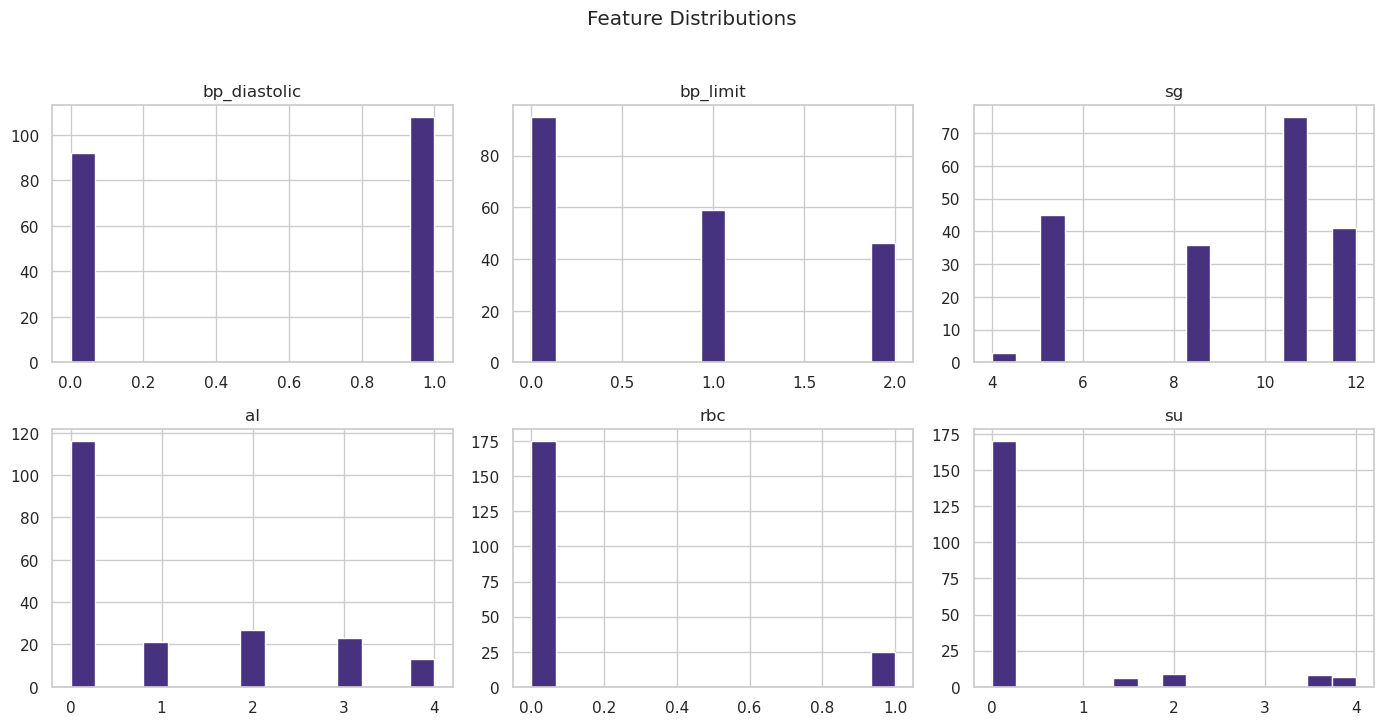

In [12]:
selected_cols = numeric_cols[:6] if len(numeric_cols) > 6 else numeric_cols
df[selected_cols].hist(bins=15, figsize=(14, 10), layout=(3, 3))
plt.suptitle('Feature Distributions', y=1.02)
plt.tight_layout()
plt.show()

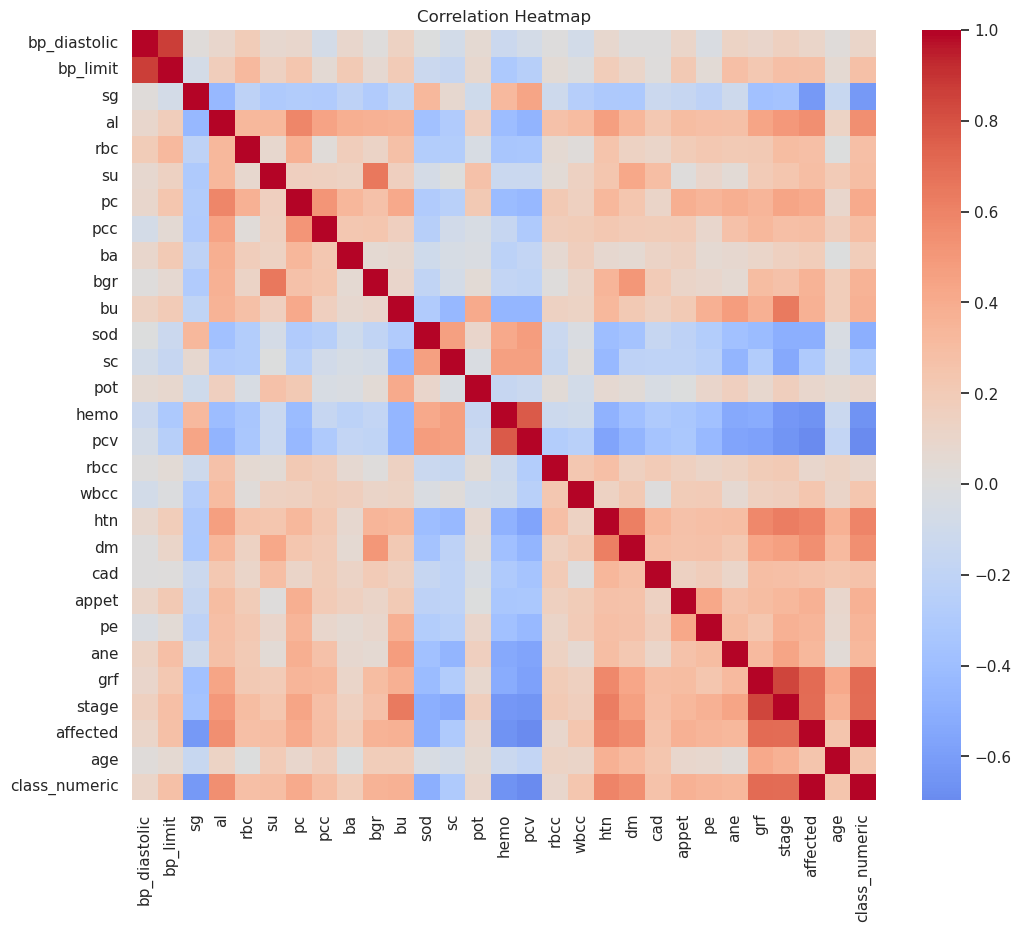

In [15]:
corr_df = df.assign(class_numeric=df['class'].map({'ckd': 1, 'notckd': 0}))
corr_matrix = corr_df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

## 5. Train/Test Split

In [16]:
X = df[feature_cols]
y = df['class'].map({'ckd': 1, 'notckd': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((160, 28), (40, 28))

## 6. Modeling with XGBoost

In [17]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, feature_cols)
])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Model Evaluation

Accuracy: 1.0
ROC AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

     Not CKD       1.00      1.00      1.00        14
         CKD       1.00      1.00      1.00        26

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



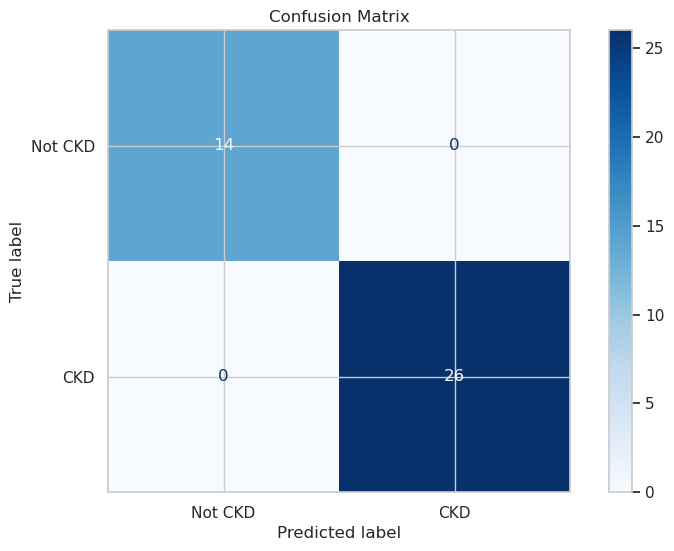

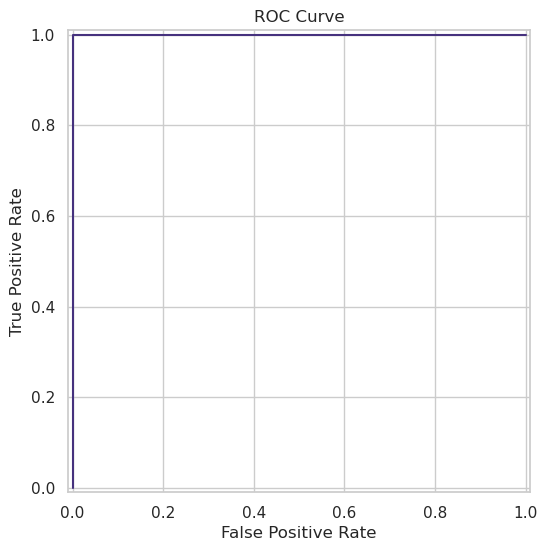

In [19]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Not CKD', 'CKD']))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not CKD', 'CKD']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title('ROC Curve')
plt.show()

## 8. Feature Importance

In [20]:
# Extract feature importances from the trained XGBoost model
booster = model.named_steps['classifier']
importances = booster.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)
importance_df.head(15)

,feature,importance
26,affected,0.423502
14,hemo,0.331122
2,sg,0.205492
24,grf,0.032068
25,stage,0.007649
10,bu,0.000168
6,pc,0.000000
5,su,0.000000
3,al,0.000000
4,rbc,0.000000


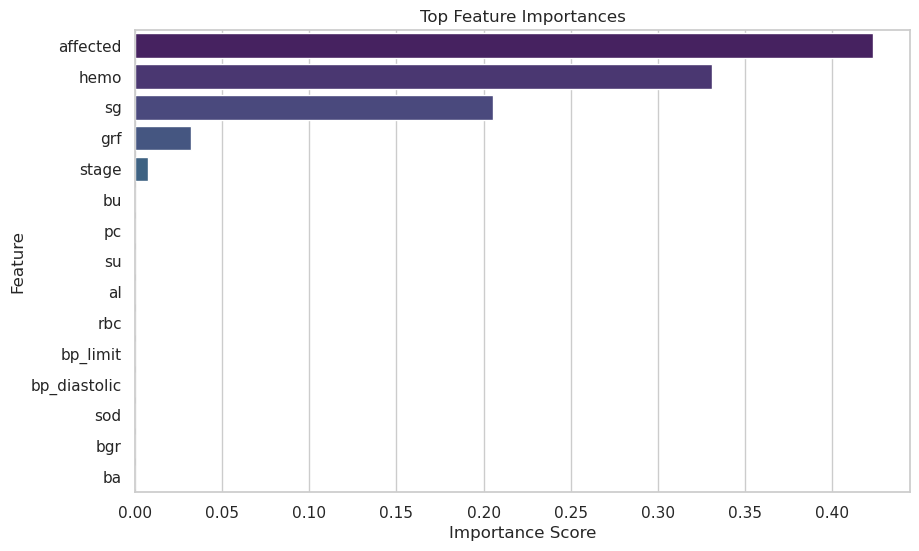

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## 9. Save Pipeline

In [22]:
model_path = MODEL_DIR / 'ckd_xgb_pipeline.joblib'
joblib.dump(model, model_path)
print(f'Model pipeline saved to {model_path}')

Model pipeline saved to models/ckd_xgb_pipeline.joblib


## 10. Helper Prediction Function

In [23]:
def predict_ckd_probability(model_pipeline, sample_dict):
    """
    Predict CKD probability for a single patient entry.
    sample_dict should map feature names to values in the same format as the cleaned dataset.
    """
    sample_df = pd.DataFrame([sample_dict])
    proba = model_pipeline.predict_proba(sample_df)[0, 1]
    return float(proba)

example_input = X_test.iloc[0].to_dict()
example_probability = predict_ckd_probability(model, example_input)
print('Example patient probability of CKD:', round(example_probability, 4))
print(json.dumps(example_input, indent=2))

Example patient probability of CKD: 0.0176
{
  "bp_diastolic": 0.0,
  "bp_limit": 0.0,
  "sg": 10.5,
  "al": 0.0,
  "rbc": 0.0,
  "su": 0.0,
  "pc": 0.0,
  "pcc": 0.0,
  "ba": 0.0,
  "bgr": 133.0,
  "bu": 24.5,
  "sod": 140.5,
  "sc": 34.0,
  "pot": 19.0,
  "hemo": 9.5,
  "pcv": 25.0,
  "rbcc": 24.5,
  "wbcc": 4980.0,
  "htn": 0.0,
  "dm": 0.0,
  "cad": 0.0,
  "appet": 0.0,
  "pe": 0.0,
  "ane": 0.0,
  "grf": 156.25,
  "stage": 1.0,
  "affected": 0.0,
  "age": 31.0
}
